In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo                    # wind_dir_speed
import metpy.calc as mpcalc
from metpy.units import units
import lcl

from windrose import WindroseAxes
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [6]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [7]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')

In [8]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [11]:
#### list of dates for slicing 
dates_start =  ['2020-02-01T01:30:00.000000000', '2020-02-09T01:30:00.000000000',\
                '2020-02-17T01:30:00.000000000', '2020-02-26T01:30:00.000000000']

dates_end = ['2020-02-08T22:30:00.000000000','2020-02-16T22:30:00.000000000',\
             '2020-02-25T22:30:00.000000000', '2020-02-29T22:30:00.000000000']

In [9]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)

# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [7]:
# load U component
U_day = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U_day = U_day['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')) #.groupby('time_counter.day').mean()

i = np.arange(0, sea_mask.shape[1])
U_day = 0.5*(U_day[:,:,:,i] + U_day[:,:,:,i+1])

In [8]:
# select data oversea
U_day = U_day.where(sea_mask, drop=False)

In [9]:
U_fst = U_day.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-08T22:30:00.000000000'))
U_snd = U_day.sel(time_counter=slice('2020-02-09T01:30:00.000000000', '2020-02-16T22:30:00.000000000'))
U_trd = U_day.sel(time_counter=slice('2020-02-17T01:30:00.000000000', '2020-02-25T22:30:00.000000000'))
U_lst = U_day.sel(time_counter=slice('2020-02-26T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [10]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_4weeks.npy', [U_fst, U_snd, U_trd, U_lst])

file already exists - DELETING IT and creating it anew


In [23]:
# load V component
V_day = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V_day = V_day['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()

j = np.arange(0, sea_mask.shape[0])
V_day = 0.5*(V_day[:,:,j,:] + V_day[:,:,j+1,:])

In [24]:
# select data oversea
V_day = V_day.where(sea_mask, drop=False)

In [25]:
V_fst = V_day.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-08T22:30:00.000000000'))
V_snd = V_day.sel(time_counter=slice('2020-02-09T01:30:00.000000000', '2020-02-16T22:30:00.000000000'))
V_trd = V_day.sel(time_counter=slice('2020-02-17T01:30:00.000000000', '2020-02-25T22:30:00.000000000'))
V_lst = V_day.sel(time_counter=slice('2020-02-26T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

del V_day

In [26]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_4weeks.npy', [V_fst, V_snd, V_trd, V_lst])

file already exists - DELETING IT and creating it anew


In [27]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)
# pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0

In [ ]:
dates_start =  ['2020-02-01T01:30:00.000000000', '2020-02-09T01:30:00.000000000',\
                '2020-02-17T01:30:00.000000000', '2020-02-26T01:30:00.000000000']

dates_end = ['2020-02-08T22:30:00.000000000','2020-02-16T22:30:00.000000000',\
             '2020-02-25T22:30:00.000000000', '2020-02-29T22:30:00.000000000']

In [28]:
pot_fst = pot_temp_full.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-08T22:30:00.000000000'))
pot_snd = pot_temp_full.sel(time_counter=slice('2020-02-09T01:30:00.000000000', '2020-02-16T22:30:00.000000000'))
pot_trd = pot_temp_full.sel(time_counter=slice('2020-02-17T01:30:00.000000000', '2020-02-25T22:30:00.000000000'))
pot_lst = pot_temp_full.sel(time_counter=slice('2020-02-26T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

del pot_temp_full

In [29]:
my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/PotTemp_4weeks_feb.npy', [pot_fst, pot_snd, pot_trd, pot_lst])

file already exists - DELETING IT and creating it anew


In [6]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
GPH = GPH['PH']

GPH = (GPH_base + GPH)/9.81
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

# GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [7]:
GPH_fst = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-08T22:30:00.000000000'))
GPH_snd = GPH.sel(time_counter=slice('2020-02-09T01:30:00.000000000', '2020-02-16T22:30:00.000000000'))
GPH_trd = GPH.sel(time_counter=slice('2020-02-17T01:30:00.000000000', '2020-02-25T22:30:00.000000000'))
GPH_lst = GPH.sel(time_counter=slice('2020-02-26T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

del GPH

In [8]:
my_save_data('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_4weeks_feb.npy', [GPH_fst, GPH_snd, GPH_trd, GPH_lst])

file already exists - DELETING IT and creating it anew


In [6]:
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_4weeks.npy', 'rb') as f:
    v_fst = np.load(f)
    #v_snd = np.load(f)
    #v_trd = np.load(f)
    #v_lst = np.load(f)
    f.close()
    
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_4weeks.npy', 'rb') as f:
    u_fst = np.load(f)
    #u_snd = np.load(f)
    #u_trd = np.load(f)
    #u_lst = np.load(f)
    f.close()
    
#del v_fst, u_fst, v_snd, u_snd, v_trd, u_trd

In [7]:
with open('/venus/tesi_ale/data_EU/T/daily/FEB/PotTemp_4weeks_feb.npy', 'rb') as f:
    temp_fst = np.load(f)
    #temp_snd = np.load(f)
    #temp_trd = np.load(f)
    #temp_lst = np.load(f)
    f.close()
    

#del temp_fst, temp_snd, temp_trd

In [8]:
with open('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_4weeks_feb.npy', 'rb') as f:
    gph_fst = np.load(f)
    #gph_snd = np.load(f)
    #gph_trd = np.load(f)
    #gph_lst = np.load(f)
    f.close()
    
#del gph_fst, gph_snd, gph_trd

In [9]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(temp_fst)
for i in range(39):
    GPH_inter[:,i,:,:] = (gph_fst[:,i+1,:,:]+gph_fst[:,i,:,:])*0.5

In [ ]:
#### smoothing out for large scale fields computation

s = 100

GPH_smooth = np.zeros(GPH_inter.shape)
temp_smooth = np.zeros(temp_fst.shape)

for t in range(0,GPH_inter.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,GPH_inter.shape[1]):
        GPH_smooth[t,h] = gm.nan_gaussian_filter(GPH_inter[t,h],s) 
        temp_smooth[t,h] = gm.nan_gaussian_filter(temp_fst[t,h],s)

In [ ]:
#### smoothing out for large scale fields computation

s = 100

u_smooth = np.zeros(u_fst.shape)
v_smooth = np.zeros(v_fst.shape)

for t in range(0,GPH_inter.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,GPH_inter.shape[1]):
        u_smooth[t,h] = gm.nan_gaussian_filter(u_fst[t,h],s) 
        v_smooth[t,h] = gm.nan_gaussian_filter(v_fst[t,h],s)

0
10
20
30
40


In [24]:
# STEP 3 --- divide
Ri_full_lst = meteo.richardson_number(GPH_inter, temp_lst, u_lst, v_lst)

In [25]:
my_save_data('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_lst.npy', [Ri_full_lst.magnitude])

In [7]:
fst = np.load('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_fst.npy')
snd = np.load('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_snd.npy')
trd = np.load('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_trd.npy')
lst = np.load('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_lst.npy')

In [15]:
my_save_data('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_lst.npy', [lst])

file already exists - DELETING IT and creating it anew


In [13]:
RI = np.concatenate([fst,snd,trd,lst], axis=0)

In [17]:
num_days = int(RI.shape[0]/8)
RI_day = np.empty((num_days, *RI.shape[1:]))

for i in range(num_days):
    RI_day[i] = np.nanmean( RI[ i*8:(i+1)*8 ,:,:] , axis=0)

In [25]:
my_save_data('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_3h_feb.npy', [RI])

In [32]:
## compute distributions
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_Ri, pstd_Ri, pstderr_Ri, pnpoints_Ri, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri_full.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [90]:
Ri_mean = meteo.richardson_number(GPH_smooth, pot_temp_mean, U_mean, V_mean) 

In [108]:
my_save_data('/venus/tesi_ale/data_EU/RI/daily/FEB/RI_meanLS_day_feb.npy', [Ri_mean.magnitude])

file already exists - DELETING IT and creating it anew


In [91]:
##### COMPUTING PERCENTAGE CHANGE IN LS RI AND SS RI
Ri_change = 100*(Ri_full - Ri_mean)/(Ri_mean)

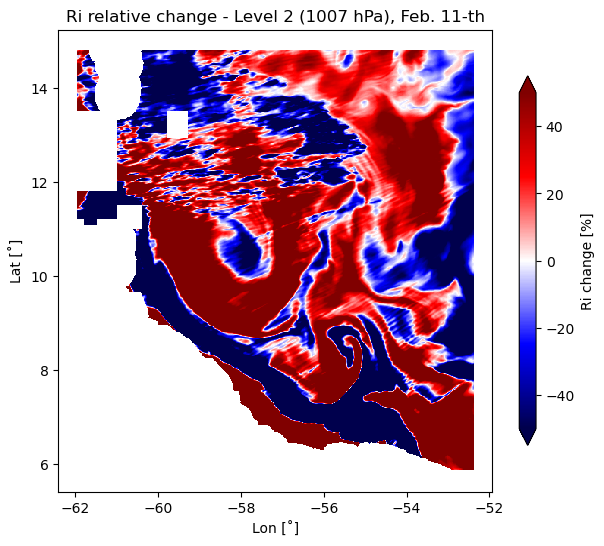

In [106]:
minval = -50 #if perc else -0.05
maxval = -minval 
level = int(2); day = int(10)

######### THIS IS FOR RIFULL/RIMEAN
# title = f'$Ri_{{full}}$ / $Ri_{{LS}}$ - Level {level} ({int(mean_vert_pres[level])} hPa), Feb. {day+1}-th'


# fig, ax1 = plt.subplots(figsize=(7, 6))  
# p1 = plt.pcolormesh(lon_M, lat_M, Ri_full[day,level,:,:]/Ri_mean[day,level,:,:], cmap='jet', vmin=minval, vmax=maxval)
# ax1.set_xlabel('Lon [˚]'); ax1.set_ylabel('Lat [˚]')
# ax1.set_title(f'{title}')
# cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
# cbar.set_label('$Ri_{full}$ / $Ri_{LS}$')



#########  THIS IS FOR RELATIVE CHANGE
title=f'Ri relative change - Level {level} ({int(mean_vert_pres[level])} hPa), Feb. {day+1}-th'

fig, ax1 = plt.subplots(figsize=(7, 6))  
p1 = plt.pcolormesh(lon_M, lat_M, Ri_change[day,level,:,:], cmap='seismic', vmin=minval, vmax=maxval)
ax1.set_xlabel('Lon [˚]'); ax1.set_ylabel('Lat [˚]')
ax1.set_title(f'{title}')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('Ri change [%]')


######## THIS IS FOR THE FULL RI
# title=f'Level {level} ({int(mean_vert_pres[level])} hPa) Richardson number, Feb. {day+1}-th'

# fig, ax1 = plt.subplots(figsize=(6, 5))  
# p1 = plt.pcolormesh(lon_M, lat_M, Ri_full[day,level,:,:], cmap='seismic', vmin=minval, vmax=maxval)
# ax1.set_xlabel('Lon [˚]'); ax1.set_ylabel('Lat [˚]')
# ax1.set_title(f'{title}')
# cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
# cbar.set_label('Ri')



In [15]:
s = 100

dRi = np.zeros(Ri.shape)

for t in range(0,Ri.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,BV_freq.shape[1]):
        ri_ave = gm.nan_gaussian_filter(Ri[t,h].magnitude,s)                               
        dRi[t,h] = Ri[t,h].magnitude - ri_ave

0
10
20


In [ ]:
## compute distributions of dRi
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dRi, pstd_dRi, pstderr_dRi, pnpoints_dRi, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

/venus/tesi_ale/img_EU/BV/daily/FEB/pdist_dsst_dBV_lowtropo.png


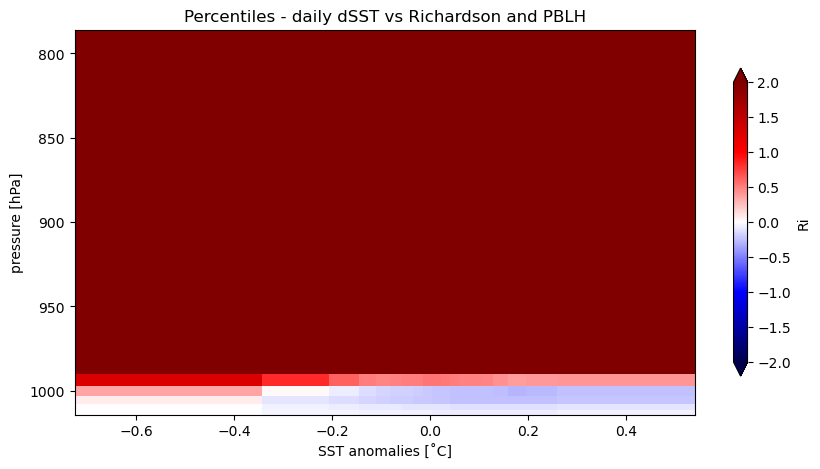

In [35]:
p_level_plot = int(15)

perc = True
x = pdist_dsst #if perc else dist_dsst_day
var = pdist_Ri[0:p_level_plot,:] #if perc else dist_dBV_freq_day[0:p_level_plot,:]*100000
minval = -2. #if perc else -0.05
maxval = -minval
title = 'Percentiles' #if perc else 'Fixed bins'

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs Richardson and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('Ri')


'''x_pbl = pdist_dsst #if perc else dist_dsst
var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 925, 'PBLH', fontsize=12)'''



'''# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] #if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')'''


path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
print(filename)
del filename

In [ ]:
### RICHARDSON VS dSST distributions

perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_Ri, pstd_Ri, pstderr_Ri, pnpoints_Ri, ppvalue_Ri_sub = \
dist_3d_subsample(dsst_day, Ri_feb, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

In [22]:
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_4weeks.npy', 'rb') as f:
    v_fst = np.load(f)
    v_snd = np.load(f)
    v_trd = np.load(f)
    v_lst = np.load(f)
    f.close()
    
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_4weeks.npy', 'rb') as f:
    u_fst = np.load(f)
    u_snd = np.load(f)
    u_trd = np.load(f)
    u_lst = np.load(f)
    f.close()
    
del v_fst, u_fst, v_snd, u_snd, v_trd, u_trd

In [23]:
with open('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_4weeks_feb.npy', 'rb') as f:
    gph_fst = np.load(f)
    gph_snd = np.load(f)
    gph_trd = np.load(f)
    gph_lst = np.load(f)
    f.close()
    
del gph_fst, gph_snd, gph_trd


In [24]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(v_lst)
for i in range(39):
    GPH_inter[:,i,:,:] = (gph_lst[:,i+1,:,:]+gph_lst[:,i,:,:])*0.5

In [25]:
dudz = (mpcalc.first_derivative(u_lst*units('m/s'), axis=1, x=GPH_inter*units.meters))**2
dvdz = (mpcalc.first_derivative(v_lst*units('m/s'), axis=1, x=GPH_inter*units.meters))**2

In [26]:
shear_lst = dudz+dvdz

my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_lst.npy', [shear_lst.magnitude])

creating new file and saving variables


In [3]:
shear_fst = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_fst.npy')
shear_snd = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_snd.npy')
shear_trd = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_trd.npy')
shear_lst = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_lst.npy')


In [4]:
shear = np.concatenate([shear_fst,shear_snd,shear_trd,shear_lst], axis=0)

# daily means
num_days = int(shear.shape[0]/8)
shear_day = np.empty((num_days, *shear.shape[1:]))

for i in range(num_days):
    shear_day[i] = np.nanmean( shear[ i*8:(i+1)*8 ,:,:] , axis=0)

In [6]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/shear_day.npy', [shear_day])

creating new file and saving variables


In [23]:
with open('/venus/tesi_ale/data_EU/T/daily/FEB/PotTemp_4weeks_feb.npy', 'rb') as f:
    temp_fst = np.load(f)
    temp_snd = np.load(f)
    temp_trd = np.load(f)
    temp_lst = np.load(f)
    f.close()
    

del temp_fst, temp_snd, temp_trd

In [24]:
with open('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_4weeks_feb.npy', 'rb') as f:
    gph_fst = np.load(f)
    gph_snd = np.load(f)
    gph_trd = np.load(f)
    gph_lst = np.load(f)
    f.close()
    
del gph_fst, gph_snd, gph_trd

# vertical interpolation of geopotential
GPH_inter = np.zeros_like(temp_lst)
for i in range(39):
    GPH_inter[:,i,:,:] = (gph_lst[:,i+1,:,:]+gph_lst[:,i,:,:])*0.5

In [26]:
# compute daily means of N2
# CALCULATE BRUNT VAISALA
N2_lst = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, temp_lst*units.kelvin, vertical_dim = 1)

In [27]:
my_save_data('/venus/tesi_ale/data_EU/BV/daily/FEB/N2_lst.npy', [N2_lst.magnitude])

In [28]:
del temp_lst,gph_lst

In [30]:
N2_fst = np.load('/venus/tesi_ale/data_EU/BV/daily/FEB/N2_fst.npy')
N2_snd = np.load('/venus/tesi_ale/data_EU/BV/daily/FEB/N2_snd.npy')
N2_trd = np.load('/venus/tesi_ale/data_EU/BV/daily/FEB/N2_trd.npy')

In [35]:
N2_lst[0,0,220,330]

-0.000113727234 <Unit('1 / second ** 2')>

In [36]:
N2 = np.concatenate([N2_fst,N2_snd,N2_trd,N2_lst.magnitude], axis=0)

In [37]:

# daily means
num_days = int(N2.shape[0]/8)
N2_day = np.empty((num_days, *N2.shape[1:]))

for i in range(num_days):
    N2_day[i] = np.nanmean( N2[ i*8:(i+1)*8 ,:,:] , axis=0)

In [39]:
my_save_data('/venus/tesi_ale/data_EU/BV/daily/FEB/N2_day.npy', [N2_day])

In [27]:
# i need weekly data of dsst for this
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst = sst.where(sea_mask, drop=False) 


In [19]:
s = 100

for i in range(len(filenames)):
    sst_slice = sst.sel(time_counter=slice(dates_start[i], dates_end[i])).values
    sst_slice = sst_slice[::3, :,:]
    dsst = np.zeros_like(sst_slice)
    
    for t in range(0,dsst.shape[0]):
        T2_smooth = gm.nan_gaussian_filter(sst_slice[t],s)                             
        dsst[t] = sst_slice[t] - T2_smooth
    
    my_save_data(path+filenames[i], [dsst])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [ ]:
## compute daily means of derivative terms in Ri
files_dsst = [ 'dsst_fst.npy', 'dsst_snd.npy', 'dsst_trd.npy', 'dsst_lst.npy']
files_dsst = ['/venus/tesi_ale/data_EU/SST/daily/FEB/' + file for file in files_dsst]
              
files_N2 = [ 'N2_fst.npy', 'N2_snd.npy', 'N2_trd.npy', 'N2_lst.npy']
files_N2 = ['/venus/tesi_ale/data_EU/BV/daily/FEB/' + file for file in files_N2]
              
files_shear = [ 'shear_fst.npy', 'shear_snd.npy', 'shear_trd.npy', 'shear_lst.npy']
files_shear = ['/venus/tesi_ale/data_EU/WIND/daily/FEB/' + file for file in files_shear]


In [3]:
# first derivative term
levels = [0,1,2]
linreg = np.zeros((4,3))
corr_coeff, p_value, p_val_cann, sigmas = np.zeros_like(linreg), np.zeros_like(linreg), np.zeros_like(linreg), np.zeros_like(linreg)

for i in range(len(levels)):
    linreg[0,i] , corr_coeff[0,i], p_value[0,i], p_val_cann[0,i], sigmas[0,i] = slopes_r_p_mix(dsst, N2_fst[:,levels[i],:,:] nt, nskip)

SyntaxError: invalid syntax (2044566413.py, line 3)

In [2]:
levels = [0,1,2]


int